# Random Forest and Gradient Boosting Classifiers Notebook

This notebook contains the experimentations done to find the best model and better understand the workings of the model. We mostly focused on the Random Forest.

If you're looking for the best model, it can be found at the bottom of this notebook.

In [1]:
%load_ext autoreload
%autoreload 2


## classic pydata stack
import os 
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30,10)
VERY_SMALL_SIZE = 4
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
import sys

import vanilla_NN as NN

sys.path.append('..')
from pipeline import *
from models import *


##### How to normally preprocess the data

You can specify a save path, to save the dataset locally. We have provided you with the zip of the two most used preprocessed datasets in this notebook, namely 'backbone_bulky4_data_1', which means that the bulky element is '4' and num_blocks is 1, and 'backbone_bulky4_data_5'.

In [47]:
pipe = AA0066_Pipeline(num_blocks=1)

dataset = PolymerDataset(data_paths=["AA00400AA.npy","AA66466AA.npy"],pipeline=pipe)

Processing AA66466AA.npy: 100%|██████████| 14185/14185 [02:40<00:00, 88.26it/s] 


In [28]:
def kfold_cv_iter(y: np.ndarray, tx: np.ndarray, k: int = 5, seed: float = 1):
    """K-fold cross validation. Split data into k parts and iterate through the folds
    Args:
        y (np.ndarray): Label data
        tx (np.ndarray): Features data
        k (int, optional): Number of folds. Defaults to 5.
        seed (float, optional): Seed for randomization. Defaults to 1.
    Yields:
        Generator: (x_train, y_train, x_test, y_test)
    """
    num_row = y.shape[0]
    fold_size = int(num_row / k)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = list(set(range(num_row)) - set(test_indices))
        yield tx[train_indices], y[train_indices], tx[test_indices], y[test_indices]


In [29]:
def train_random_forest(tx,y, k=5, n_estimators = 100):
    
    accuracies = []
    importances = []

    iter = kfold_cv_iter(y,tx,k=k,seed=2)
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = n_estimators )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)
        importances.append(classifier.feature_importances_)

    accuracies = np.array(accuracies)
    importances = np.array(importances)
    
    return accuracies, importances, classifier

## Random forest with removing a feature

Taking num_blocks = 1, we drop features to see if accuracy drops in our random forest

In [107]:
names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
## loading preprocessed data
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)


# iterating over all features

for i in range(len(names)):
    #loading data
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    ## removing a feature
    mask = np.zeros((9), dtype=bool)
    mask[i] = True
    tx =tx[:,np.logical_not(mask)]
    #training the forest
    forest = train_random_forest(tx, y, k=5)
    accuracies = forest[0]

    print(f"Removing feature {names[i]}: ",np.array(accuracies).mean())


Removing feature mean:  0.9498006843757717
Removing feature median:  0.9479309979892051
Removing feature std:  0.9354076269093731
Removing feature min:  0.935301795604473
Removing feature max:  0.9464846368222387
Removing feature len:  0.9461318658059054
Removing feature count_extremums:  0.9495890217659717
Removing feature max_slope:  0.9508237203231383
Removing feature min_slope:  0.9491656965463718


## Random forest with different num_blocks

We iterate over 10 preprocessed datasets from num_blocks = 1 to num_blocks = 10. This will let us design the ideal num_blocks parameter.

In [6]:
feature_importances = []
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)

## iterating over the preprocessed datasets

for i in range(1,11):
    # loading data
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    #training the forest
    forest = train_random_forest(tx, y, k=5)
    accuracies = forest[0]

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())

num_blocks=1 :  0.9506120577133382
num_blocks=2 :  0.9566444420926378
num_blocks=3 :  0.9583377429710375
num_blocks=4 :  0.9586199597841042
num_blocks=5 :  0.9594313331216707
num_blocks=6 :  0.9579496948530708
num_blocks=7 :  0.9571735986171376
num_blocks=8 :  0.9562916710763044
num_blocks=9 :  0.9564680565844711
num_blocks=10 :  0.9506120577133382


In [39]:
def train_and_plot_feature_importances_(num_blocks, save=True):

    path = f"backbone_bulky4_data_{num_blocks}.npy"
    y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    forest = train_random_forest(tx,y)


    features = forest[1].mean(axis=0)
    names=["mean", "median", "std", "min", "max", "len", "num_extremums", "max_slope", "min_slope"]

    savepath=None

    if save:
        savepath = f"random_forest_feature_importances_{num_blocks}.png"

    title = f"Random Forest Gini Impurity-based Features Importances (num_blocks={num_blocks})"

    plot_feature_importances(feature_importances = features, names=names, num_blocks=num_blocks, title=title, savepath=savepath)

In [40]:
def plot_feature_importances(feature_importances, names, num_blocks,title, savepath=None):

    df = pd.DataFrame()
    df['names'] = pd.Series(names*num_blocks)
    df['features'] = pd.Series(feature_importances)
    df['block_number'] = pd.Series([i  for i in range(1,num_blocks+1) for j in range(len(names))]) 

    f,a = plt.subplots(1,1,figsize=(30,15))
    g= sns.barplot(x='names', y='features', data=df, hue='block_number')
    g.set_title(title)
    g.set_xlabel("Feature names")
    g.set_ylabel("Feature importance")

    if savepath:
        plt.savefig(savepath, dpi=300)

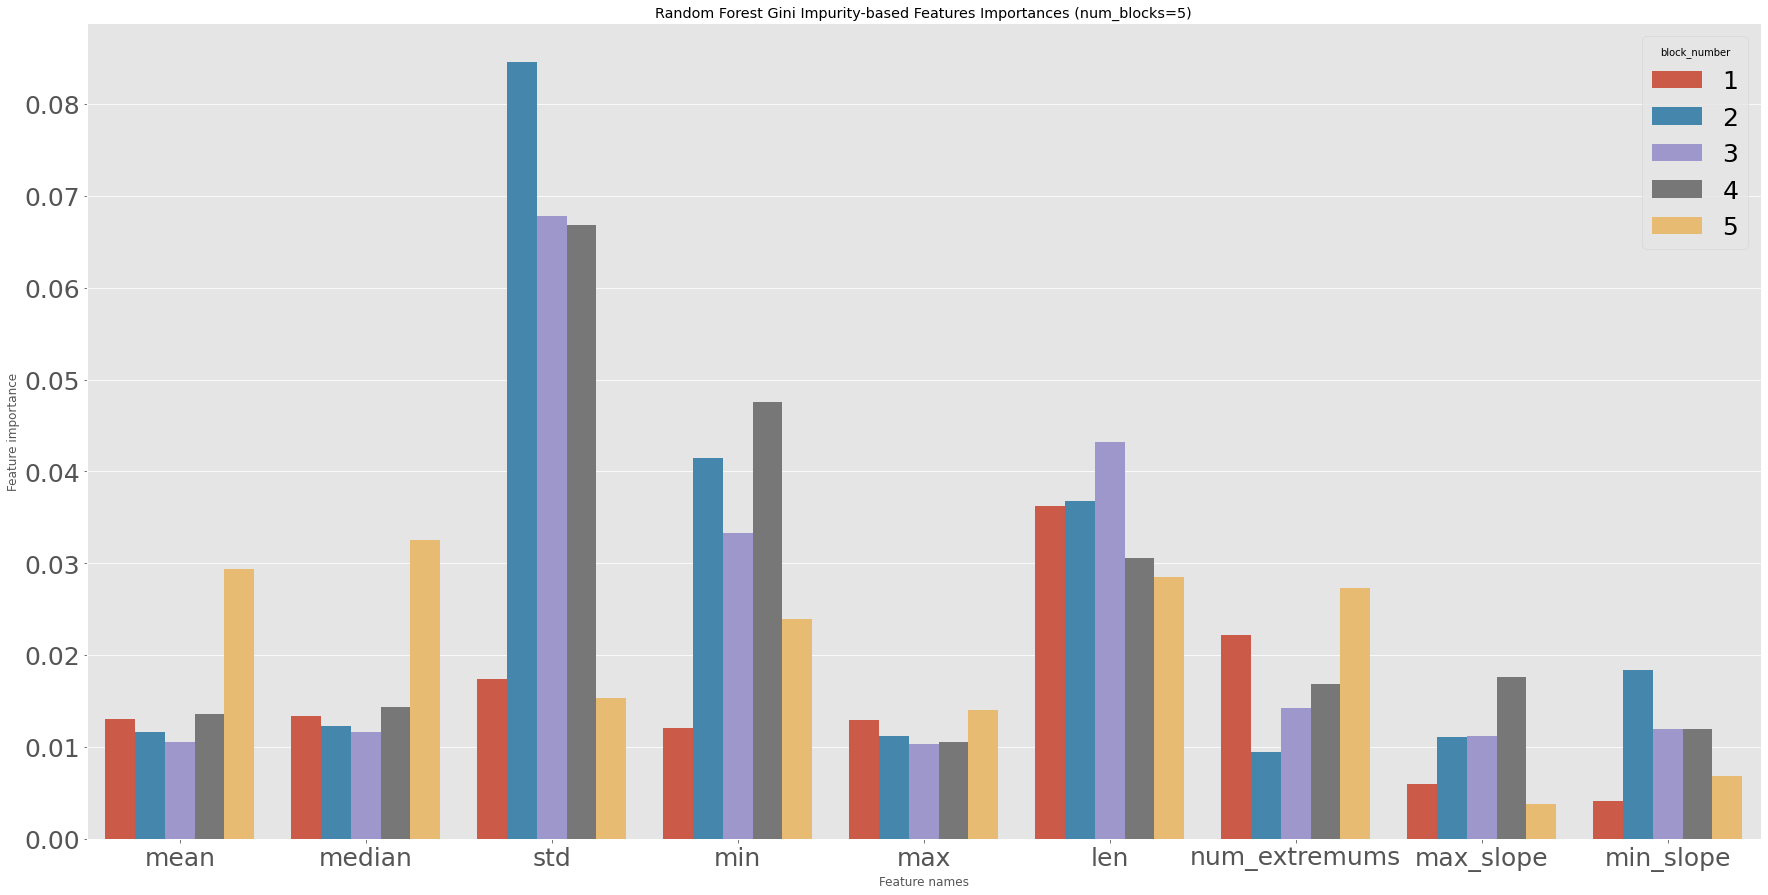

In [41]:
train_and_plot_feature_importances_(num_blocks=5,save=False)

## Testing different feature importance

In [11]:
num_blocks=5
path = f"backbone_bulky4_data_{num_blocks}.npy"
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))
forest = train_random_forest(tx=tx,y=y)

clf= forest[2]

from sklearn.inspection import permutation_importance

result = permutation_importance(clf,tx,y,n_repeats=10, random_state=0)

result.importances_mean

array([ 2.53995132e-04,  2.99855364e-04,  8.14901048e-04,  3.24549335e-04,
        8.04317917e-04,  2.11662610e-04,  1.41108407e-04,  2.92799944e-04,
       -1.41108407e-05,  3.24549335e-04,  3.73937277e-04,  5.35506403e-03,
        4.77299185e-03,  7.09069743e-04,  1.09359015e-04,  1.23469856e-04,
        7.37291424e-04,  1.66860691e-03,  1.09359015e-04,  2.04607189e-04,
        7.22475041e-03,  2.61756094e-03,  1.83440928e-04,  1.19942146e-04,
        2.46939711e-05,  7.76096236e-04,  4.09214379e-04,  6.13821568e-04,
        3.31604755e-04,  4.88235087e-03,  8.42417187e-03,  5.99710728e-04,
        1.86968639e-04, -1.41108407e-05,  7.97262497e-04,  4.33908350e-04,
        5.64433626e-04,  7.76096236e-04,  8.21956468e-04,  5.82072177e-04,
        7.26708294e-04,  1.44636117e-04,  2.46939711e-04,  7.05542033e-05,
        3.63354147e-04])

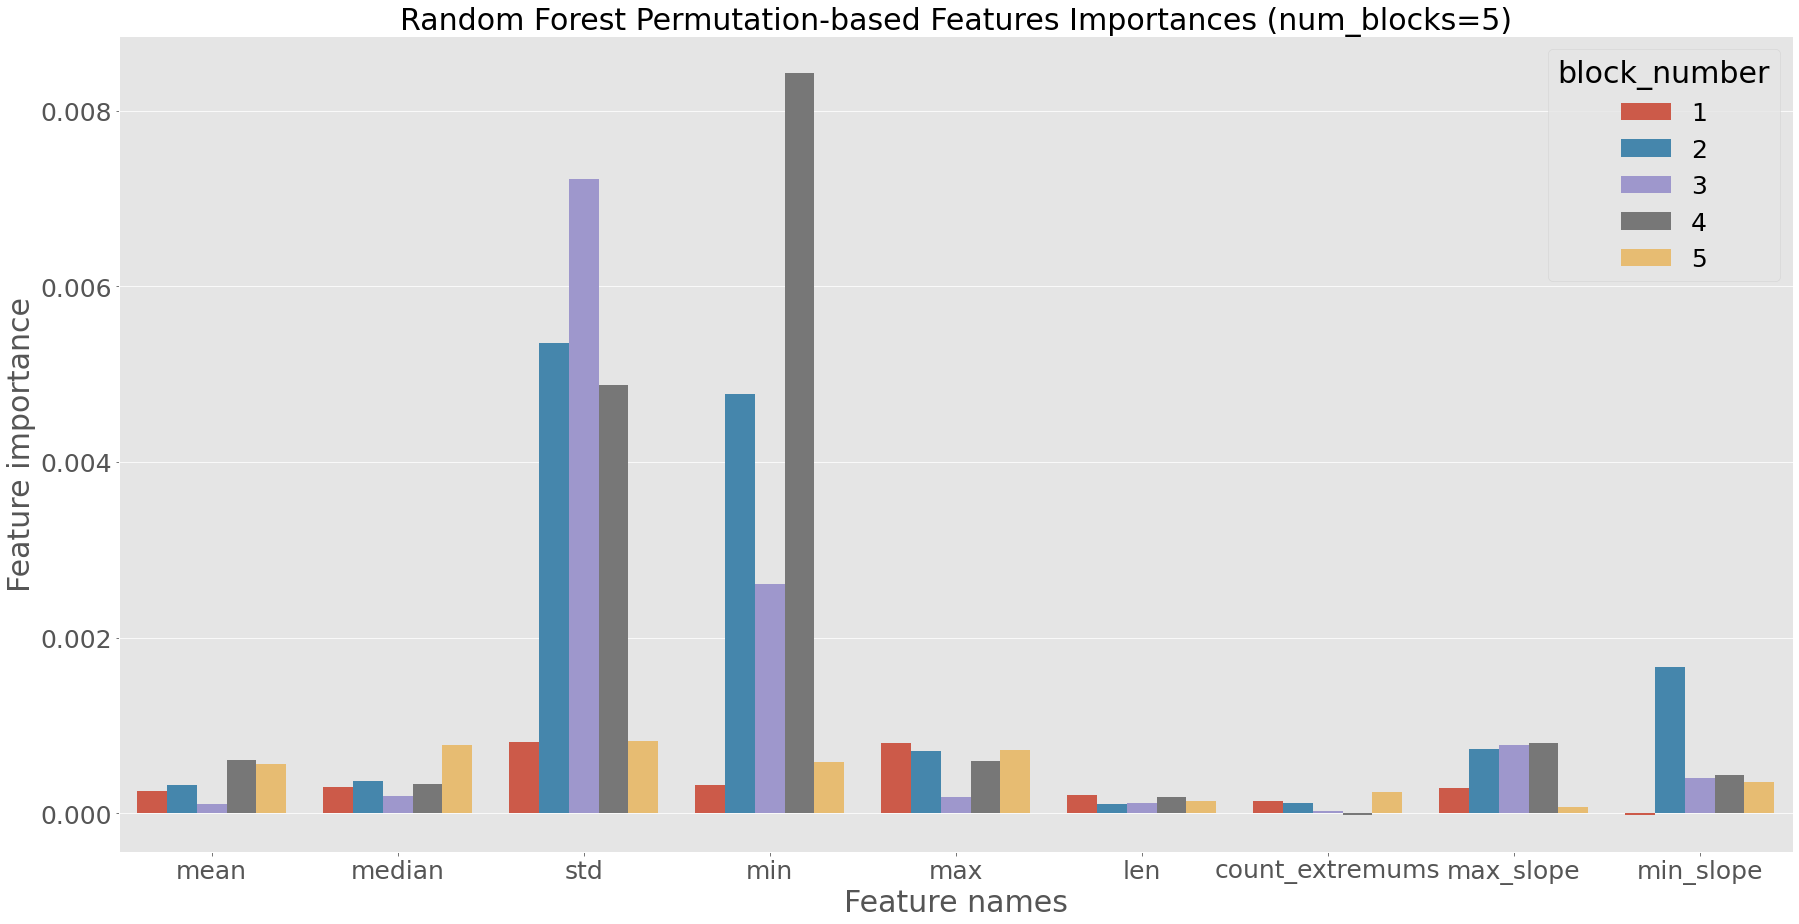

In [21]:
title = f"Random Forest Permutation-based Features Importances (num_blocks={num_blocks})"

plot_feature_importances(feature_importances = result.importances_mean, names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"], num_blocks=num_blocks, title=title, savepath= f"random_forest_permutation_importance_{num_blocks}")

## Gradient boosting classifier

Experimentations with the Gradient Boosting classifier. It is in the middle of the notebook

### Gradient boosting classifier with removing a feature

In [105]:
from sklearn.ensemble import GradientBoostingClassifier

names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
from sklearn.metrics import accuracy_score

for i in range(9):
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    mask = np.zeros((9), dtype=bool)
    mask[i] = True

    tx =tx[:,np.logical_not(mask)]


    iter = kfold_cv_iter(y,tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier =GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(names[i],": ",np.array(accuracies).mean())


mean :  0.9448266130454721
median :  0.9422866617278723
std :  0.9335379405228067
min :  0.9263766888912407
max :  0.9379475782269728
len :  0.9400289272233393
count_extremums :  0.9446855046389389
max_slope :  0.9445443962324056
min_slope :  0.9424630472360391


 ## Gradient boosting classifier with different num_blocks

In [106]:
for i in range(1,11):
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    iter = kfold_cv_iter(y,tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())

num_blocks=1 :  0.944050516809539
num_blocks=2 :  0.9525522983031713
num_blocks=3 :  0.9549864183158712
num_blocks=4 :  0.9551275267224044
num_blocks=5 :  0.9546336472995378
num_blocks=6 :  0.9557625145518044
num_blocks=7 :  0.9553391893322045
num_blocks=8 :  0.9553391893322045
num_blocks=9 :  0.9547747557060712
num_blocks=10 :  0.944050516809539


## Hyperparameter tuning of random forest

We now do hyperparameter tuning using Grid search.

In [42]:
num_blocks=5
path = f"backbone_bulky4_data_{num_blocks}.npy"
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))


from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
# Maximum number of levels in tree
 'max_depth': [100, 200, 300, None],
 'criterion':['gini','entropy'],
# Number of features to consider at every split
 'max_features': ['auto', 'sqrt'],
# Minimum number of samples required at each leaf node
 'min_samples_leaf': [1, 2, 4, 10],
# Minimum number of samples required to split a node
 'min_samples_split': [2, 5, 10],
 # Number of trees in random forest
 'n_estimators': [100, 200, 500, 750, 1000, 1500, 2000],
 'n_jobs': [-1]}


clf = RandomForestClassifier(random_state=42)

rf_random = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)


rf_random.fit(tx,y)


In [45]:
import pickle

num_blocks=5
path = f"backbone_bulky4_data_{num_blocks}.npy"
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))

forest = train_random_forest(tx,y)

clf = forest[2]

pickle_filename = "model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(clf,file)

## Best model

With bulky element '4'.

In [46]:
import pickle

best_params = {'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


num_blocks=5
path = f"backbone_bulky4_data_{num_blocks}.npy"
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))


iter = kfold_cv_iter(y,tx,k=5,seed=2)
accuracies = []
for X_train, Y_train, X_test, Y_test in iter:
    classifier = RandomForestClassifier(**best_params)
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    accuracies.append(accuracy)


pickle_filename = "backbone_bulky4_rf_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(classifier,file)

accuracies = np.array(accuracies)
accuracies.mean()

0.9603104603986594

With bulky element '5'.

In [17]:
tx_5 = torch.load("backbone_bulky5_data_5").numpy()
y_5 = np.load("backbone_bulky5_labels.npy",allow_pickle=True)
tx_5 = tx_5.reshape((tx_5.shape[0],-1))


iter = kfold_cv_iter(y_5,tx_5,k=5,seed=2)
accuracies = []
for X_train, Y_train, X_test, Y_test in iter:
    classifier = RandomForestClassifier(**best_params)
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    accuracies.append(accuracy)

accuracies = np.array(accuracies)
accuracies.mean()


Processing AA66566AA.npy: 100%|██████████| 34405/34405 [01:37<00:00, 352.40it/s]


0.934657514239813